In [1]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.svm import SVR
import time

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
dataset = pd.read_csv('Delhi_New_Modified.csv', header=0, index_col=0)
values = dataset.values


In [4]:
dataset

,Month,PM10,PM2.5,Ozone,Ammonia,BarPressure,SolarRadiation,RelativeHumidity,PXylene,Toulene,AmbientTemperature,WindDirection,WindSpeed,SulphurDioxide,OxidesOfNitrogen,NitrogenDioxide,Benzene,NitricOxide
Day,,,,,,,,,,,,,,,,,,
4,4,166.93,54.21,28.15,25.69,740.0,256.38,59.87,2.99,10.27,23.28,131.07,1.48,31.30,71.09,55.13,2.04,17.55
5,4,260.41,100.50,26.79,32.94,740.0,174.72,69.64,1.29,10.60,20.74,124.15,0.91,49.68,60.74,50.65,4.39,14.14
9,4,482.61,83.02,10.17,19.10,740.0,195.47,31.26,4.15,11.10,30.16,263.99,1.50,14.93,88.52,79.48,3.15,26.31
10,4,442.78,114.30,13.88,21.90,740.0,218.36,36.18,3.12,9.84,29.81,256.34,1.26,11.17,88.50,77.10,3.18,25.48
11,4,671.70,251.78,13.12,34.07,740.0,190.72,36.42,3.80,16.47,29.92,160.78,0.97,28.10,94.08,85.62,5.40,16.94
12,4,NaN,64.32,10.91,35.03,740.0,166.27,53.08,1.25,10.97,24.30,151.32,1.77,22.88,68.94,61.65,1.86,13.48
13,4,161.80,110.57,15.89,40.28,740.0,220.57,58.09,1.92,16.19,24.91,118.04,2.01,14.95,65.21,53.87,2.75,12.58
14,4,247.32,85.98,12.53,31.52,740.0,222.34,51.91,2.30,14.17,27.01,92.46,2.22,12.52,57.69,47.47,2.13,11.40
15,4,392.29,118.89,10.57,33.08,740.0,13.64,53.99,3.20,13.70,26.89,133.69,1.01,15.88,71.82,61.52,3.07,15.33


In [5]:
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')
reframed = series_to_supervised(values, 1, 1)

In [6]:
reframed.shape

(245, 36)

In [7]:
reframed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245 entries, 1 to 283
Data columns (total 36 columns):
var1(t-1)     245 non-null float32
var2(t-1)     245 non-null float32
var3(t-1)     245 non-null float32
var4(t-1)     245 non-null float32
var5(t-1)     245 non-null float32
var6(t-1)     245 non-null float32
var7(t-1)     245 non-null float32
var8(t-1)     245 non-null float32
var9(t-1)     245 non-null float32
var10(t-1)    245 non-null float32
var11(t-1)    245 non-null float32
var12(t-1)    245 non-null float32
var13(t-1)    245 non-null float32
var14(t-1)    245 non-null float32
var15(t-1)    245 non-null float32
var16(t-1)    245 non-null float32
var17(t-1)    245 non-null float32
var18(t-1)    245 non-null float32
var1(t)       245 non-null float32
var2(t)       245 non-null float32
var3(t)       245 non-null float32
var4(t)       245 non-null float32
var5(t)       245 non-null float32
var6(t)       245 non-null float32
var7(t)       245 non-null float32
var8(t)       245 no

In [8]:
# drop columns we don't want to predict
reframed_1 = reframed.drop(reframed.columns[[0,1,-18,-17,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1]], axis=1, inplace=False)
reframed_2 = reframed.drop(reframed.columns[[0,2,-18,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1]], axis=1, inplace=False)
print(reframed_1.head())
print(reframed_2.head())



    var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var7(t-1)  var8(t-1)  \
1   54.209999  28.150000  25.690001      740.0  256.380005  59.869999   
2  100.500000  26.790001  32.939999      740.0  174.720001  69.639999   
3   83.019997  10.170000  19.100000      740.0  195.470001  31.260000   
4  114.300003  13.880000  21.900000      740.0  218.360001  36.180000   
7  110.570000  15.890000  40.279999      740.0  220.570007  58.090000   

   var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  var13(t-1)  var14(t-1)  \
1       2.99   10.270000   23.280001  131.070007        1.48   31.299999   
2       1.29   10.600000   20.740000  124.150002        0.91   49.680000   
3       4.15   11.100000   30.160000  263.989990        1.50   14.930000   
4       3.12    9.840000   29.809999  256.339996        1.26   11.170000   
7       1.92   16.190001   24.910000  118.040001        2.01   14.950000   

   var15(t-1)  var16(t-1)  var17(t-1)  var18(t-1)     var3(t)  
1   71.089996   55.130001        2.04   

In [9]:
# For PM2.5
values_1 = reframed_1.values
scaler_1 = MinMaxScaler(feature_range=(0, 1), copy=True)
scaled_features_1 = scaler_1.fit_transform(values_1[:,:-1])
scaled_label_1 = scaler_1.fit_transform(values_1[:,-1].reshape(-1,1))
values_1 = np.column_stack((scaled_features_1, scaled_label_1))

# For PM10
values_2 = reframed_2.values
scaler_2 = MinMaxScaler(feature_range=(0, 1), copy=True)
scaled_features_2 = scaler_2.fit_transform(values_2[:,:-1])
scaled_label_2 = scaler_2.fit_transform(values_2[:,-1].reshape(-1,1))
values_2 = np.column_stack((scaled_features_2, scaled_label_2))

In [10]:
values_1.shape

(245, 17)

In [11]:
values_2.shape

(245, 17)

In [12]:
# Training for PM2.5
features_1 = values_1[:,:-1]
labels_1 = values_1[:,-1]
train_X_1 , test_X_1 , train_y_1, test_y_1 = train_test_split(features_1,
                                                      labels_1,
                                                      test_size=0.25 ,
                                                      random_state=1 )

# Training for PM10
features_2 = values_2[:,:-1]
labels_2 = values_2[:,-1]
train_X_2 , test_X_2 , train_y_2, test_y_2 = train_test_split(features_2,
                                                      labels_2,
                                                      test_size=0.25 ,
                                                      random_state=1 )

In [13]:
# Fitting the data

regressor = SVR(kernel='rbf',gamma='auto')
regressor.fit(train_X_1,train_y_1)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [14]:
y_predic_1 = regressor.predict(test_X_1)
y_predic_2 = regressor.predict(test_X_2)

In [15]:
y_predic_1

array([0.19036023, 0.67652676, 0.73379327, 0.63450612, 0.13702702,
       0.67779424, 0.18368194, 0.14708321, 0.44686496, 0.24313712,
       0.1094324 , 0.06777422, 0.10867536, 0.12162449, 0.38827422,
       0.24897051, 0.43331284, 0.23891579, 0.4699561 , 0.07298736,
       0.51326442, 0.2233499 , 0.13136986, 0.39711839, 0.16363049,
       0.13586968, 0.6246706 , 0.17002406, 0.2596211 , 0.39089993,
       0.52444216, 0.27389775, 0.28703349, 0.60565192, 0.10752966,
       0.22876991, 0.21859759, 0.29476624, 0.16460404, 0.68146576,
       0.15526845, 0.23418642, 0.31710703, 0.76768587, 0.23327671,
       0.15435933, 0.32693323, 0.23623207, 0.325622  , 0.2207859 ,
       0.46016915, 0.25436731, 0.35953607, 0.21516925, 0.17137049,
       0.1423816 , 0.12452479, 0.33973596, 0.25568514, 0.59793845,
       0.56481961, 0.35185543])

In [16]:
y_predic_2


array([0.14652766, 0.55859158, 0.62600186, 0.53115424, 0.14301361,
       0.55107184, 0.15964878, 0.16138483, 0.42985265, 0.19650113,
       0.1254419 , 0.06510933, 0.10992099, 0.12099673, 0.38021692,
       0.32713406, 0.40097305, 0.19270546, 0.35291664, 0.06728213,
       0.42125007, 0.18296509, 0.1409392 , 0.3523518 , 0.14270336,
       0.13526255, 0.46298299, 0.27310531, 0.28508217, 0.397718  ,
       0.39585096, 0.26767885, 0.24674311, 0.48547797, 0.12342135,
       0.28512263, 0.25817324, 0.29447314, 0.17111866, 0.48277175,
       0.15437427, 0.1782499 , 0.31265802, 0.57777487, 0.20702956,
       0.16142189, 0.2597117 , 0.26473024, 0.32728121, 0.21884661,
       0.40111763, 0.35321429, 0.34774052, 0.20609093, 0.17048364,
       0.15081863, 0.12667344, 0.34639162, 0.29547574, 0.48059403,
       0.48954004, 0.37389949])

In [17]:
rmse_1 = np.sqrt(mean_squared_error(test_y_1, y_predic_1))
test_y_1 = scaler_1.inverse_transform(test_y_1.reshape(-1,1))
y_predic_1 = scaler_1.inverse_transform(y_predic_1.reshape(-1,1))

rmse_2 = np.sqrt(mean_squared_error(test_y_2, y_predic_2))
test_y_2 = scaler_2.inverse_transform(test_y_2.reshape(-1,1))
y_predic_2 = scaler_2.inverse_transform(y_predic_2.reshape(-1,1))

print('Root Mean Squared Error: {:.4f}'.format(rmse_1))
print("R2 score : %.2f" % r2_score(test_y_1,y_predic_1))


In [24]:
print('Root Mean Squared Error: {:.4f}'.format(rmse_1))
print("R2 score : %.2f" % r2_score(test_y_1,y_predic_1))


Root Mean Squared Error: 0.1138
R2 score : 0.79


In [25]:
print('Root Mean Squared Error: {:.4f}'.format(rmse_2))
print("R2 score : %.2f" % r2_score(test_y_2,y_predic_2))


Root Mean Squared Error: 0.0971
R2 score : 0.46


In [26]:
def plot_predicted(predicted_data, true_data):
    fig, ax = plt.subplots(figsize=(17,8))
    ax.set_title('Prediction vs. Actual ')
    ax.plot(true_data, label='True Data', color='orange', linewidth='3')
    ax.plot(predicted_data, label='Prediction', color='blue', linewidth='2')
    plt.legend()
    plt.show()


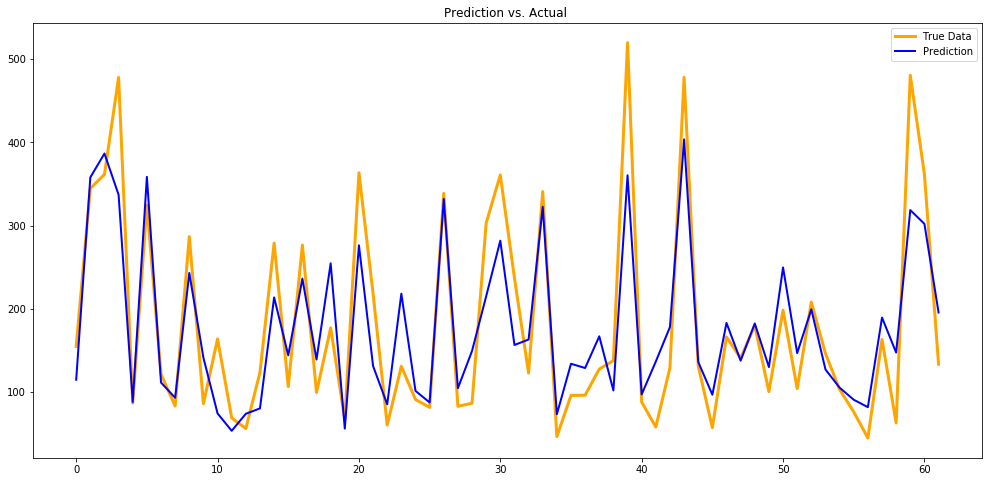

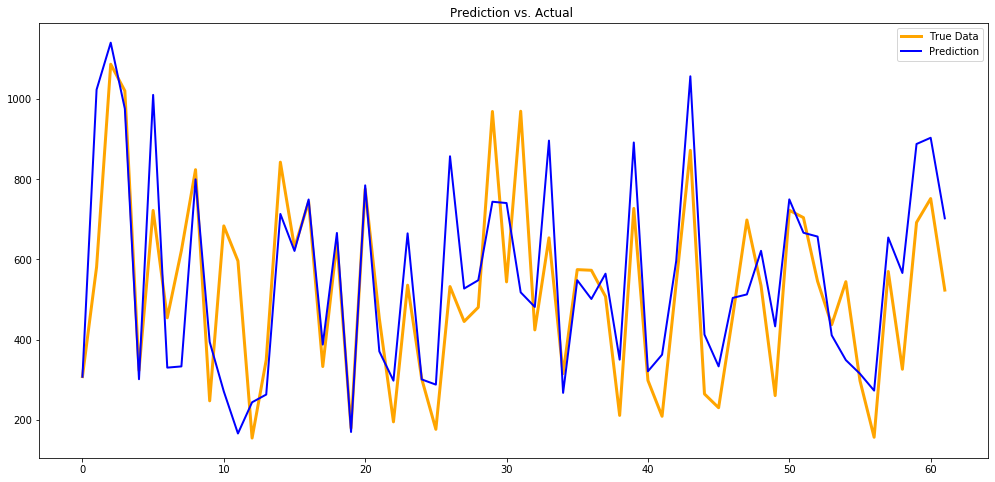

In [27]:
plot_predicted(y_predic_1[:300,], test_y_1[:300,])
plot_predicted(y_predic_2[:300,], test_y_2[:300,])